# Project 02: Achieving Critical Nuclear Fission
**Name:** Linus Widmer

## Research Question

- The primary goal of this simulation is to determine how the dimensions of the container need to be adjusted for both spheres and cubes to get the multiplication factor $k$ as closely as possible to 1 ensuring a stable and safe chain reaction. This includes simulations for many generations to observe if those $k$ values are stable or not.
- This simulations would have been useful for Fermi as they could have provided information on how the samples would have to be prepared for the most reliable critical reaction without becoming subcritical or supercritical.

## Physics used in the Simulation

The basic code has been extended in the following ways:

- **Sample Shape:**\
  The code has been upgraded to accept both a sphere of diametre $a$ or a cube of side length $a$ as possible containers for the uranium sample.

- **Uranium Purity:**\
  The uranium sample may not be perfectly pure and may have some local differences in purity throughout the sample. For simplicity it is assumed that the sample consists of a purity distribution described by the different probabilities of fission events occuring. These probabilities are assumed to range from 50% to 100% throughout the sample. To model this a uniform grid of ($100\times100\times100$) points within a cube of side length $a$ is generated. For each point a uniformly random probablitiy in the range of 50% to 100% is generated to form the probability grid.

  A new probability grid is generated for each trial. Whenever the code needs to predict whether a fission event occurs it will use the probability of the gridpoint closest to the neutron position to do so. See functions <code>probability_grid</code> and <code>event</code>.

- **Average number of neutrons produced per fission event:**\
  From the project 3 instructions I know the average number of neutrons produced per fission event is 2.4355. And according to [1], a fission reaction produces either 2 or 3 neutrons. From that we know that:
$$\mathrm{Neutrons_{ave}} = p \cdot 2 + (1-p) \cdot 3$$
where $p$ and $(p-1)$ are the probabilities of 2 or 3 neutrons being produced respectively.
$$2.4355 = p \cdot 2 + (1-p) \cdot 3$$
$$p = \frac{2.4355 - 3}{2-3} = 0.5645$$

- **Generations and general coding procedure:**\
  The function <code>optimise_a</code> initially finds the value of $a$ in the range of 0.2 m to 0.5 m corresponding to the $k$-value closest to 1. It then computes and graphs the $k$-values corresponding to that value of $a$ over 50 generations.

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def neutrons_released_generator():
    p = 0.5645                # Probability of 2 neutrons being released (derived above)
    return np.random.choice([2,3], p=[p, 1-p])

In [3]:
def probability_grid(dim, p_min, p_max, n = 100):
    x, y, z = np.linspace(-dim, dim, n), np.linspace(-dim, dim, n), np.linspace(-dim, dim, n)

    grid_prob = np.random.uniform(p_min, p_max, size = (n, n, n))

    return [[x,y,z] , grid_prob]

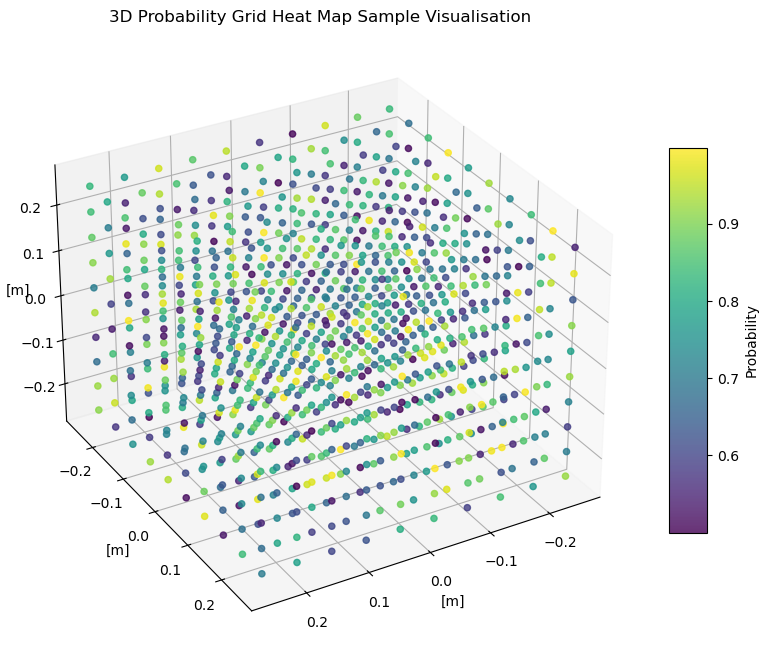

In [96]:
### Sample visualisation of probability grid with greatly reduced number of points

a = 0.5
p_min = 0.5
p_max = 1

[x,y,z], grid_prob = probability_grid(a/2, p_min, p_max, n = 10)

X, Y, Z = np.meshgrid(x,y,z)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


scatter = ax.scatter(
    X, Y, Z,
    c=grid_prob,
    cmap='viridis',
    alpha=0.8    
)


cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Probability')


ax.set_xlabel('[m]')
ax.set_ylabel('[m]')
ax.set_zlabel('[m]', labelpad = -2)
ax.set_title('3D Probability Grid Heat Map Sample Visualisation')


ax.view_init(elev=30, azim=60)

plt.show()

**Note:** This graph is not intended to provide information about the grid as it is impossible to visually determine where in the grid the inner points lie. This graph is intended to confirm that the probability grid works as intended and produces the correct output.

In [4]:
## Does an event even occur

def event(grid, particle_pos):
    
    grid_pos, grid_prob = grid

    ### Find coordinates [i,j,k] of particle in grid

    i = np.argmin(np.abs(particle_pos[0]-grid_pos[0]))
    j = np.argmin(np.abs(particle_pos[1]-grid_pos[1]))
    k = np.argmin(np.abs(particle_pos[2]-grid_pos[2]))

    prob_event = grid_prob[i, j, k]

    return np.random.choice([True, False], p=[prob_event, 1-prob_event])

In [5]:
## Check if in boundary

def cube(N, dim, grid = None, state_check = False, initialise_pos = False):
    if initialise_pos:
        x0, y0, z0 = np.random.uniform(-dim, dim, N), np.random.uniform(-dim, dim, N), np.random.uniform(-dim, dim, N)
        return x0, y0, z0

    if state_check:
        x0f, y0f, z0f = state_check
    
        
        x1, y1, z1 = [], [], []

        #neutrons_released_ls = []
        for i in range(N):
            if np.abs(x0f[i]) <= dim and np.abs(y0f[i]) <= dim and np.abs(z0f[i]) <= dim:

                if event(grid, [x0f[i], y0f[i], z0f[i]]):
                    num = neutrons_released_generator()
                    #neutrons_released_ls.append(num)
                    
                    x1 += num * [x0f[i]]
                    y1 += num * [y0f[i]]
                    z1 += num * [z0f[i]]

        #print(f"code validation: average number of neutrons produced = {np.mean(neutrons_released_ls):.4f}")
        return x1, y1, z1

In [6]:
## Check if in boundary

def sphere(N, dim, grid = None, state_check = False, initialise_pos = False):
    if initialise_pos:
        radius, theta, phi = np.random.uniform(0, dim, N), np.random.uniform(0, 2 * np.pi, N), np.random.uniform(0, np.pi, N)
        x0 = radius * np.cos(theta) * np.sin(phi)
        y0 = radius * np.sin(theta) * np.sin(phi)
        z0 = radius * np.cos(phi)
        return x0, y0, z0

    if state_check:
        x0f, y0f, z0f = state_check
    
        
        x1, y1, z1 = [], [], []

        #neutrons_released_ls = []
        for i in range(N):
            if np.sqrt(x0f[i]**2 + y0f[i]**2 + z0f[i]**2) <= dim:

                if event(grid, [x0f[i], y0f[i], z0f[i]]):
                    num = neutrons_released_generator()
                    #neutrons_released_ls.append(num)
                    
                    x1 += num * [x0f[i]]
                    y1 += num * [y0f[i]]
                    z1 += num * [z0f[i]]

        #print(f"code validation: average number of neutrons produced = {np.mean(neutrons_released_ls):.4f}")
        return x1, y1, z1

In [7]:
def fission_reaction(N, dim, mean_free_path, grid, shape, state = False):

    if N != 0:
        
        if state:
            x0, y0, z0 = state
        else:
            # Generate a random initial decay position for each neutron
            # - These positions will only be random for the Generation 0 neutrons
            if shape == 'cube':
                x0, y0, z0 = cube(N, dim, initialise_pos = True)
            if shape == 'sphere':
                x0, y0, z0 = sphere(N, dim, initialise_pos = True)
        
        # Generate random initial directions for each neutron. The mathematical convention for spherical coordinates will be used where theta is the angle from the positive x axis and phi is the angle from the positive z-axis.
        theta = np.random.uniform(0, 2 * np.pi, N)
        phi = np.random.uniform(0, np.pi, N)
        
        # Randomly generate the distance travelled for a neutron 
        # before it is absorbed. This comes from the proabability 
        # p(L) ∝ e^{-L/λ} that a thermal neutron will be captured after
        # travelling a distance L
        L = np.random.exponential(mean_free_path, N)
        
        # Unit vector in direction of L
        Lhat_x = np.cos(theta) * np.sin(phi)
        Lhat_y = np.sin(theta) * np.sin(phi)
        Lhat_z = np.cos(phi)
        
        x0f = x0 + L*Lhat_x
        y0f = y0 + L*Lhat_y
        z0f = z0 + L*Lhat_z
        
        # check if they are still in the bounds
        if shape == 'cube':
            x1, y1, z1 = cube(N, dim, grid, [x0f, y0f, z0f])
        if shape == 'sphere':
            x1, y1, z1 = sphere(N, dim, grid, [x0f, y0f, z0f])
        
        N1 = len(x1)
        k1 = N1/N
        
        return N1, k1, (x1, y1, z1)

    else:
        return 0, 0, False

In [8]:
def generations(gen, N, dim, mean_free_path, trials, shape, p_min, p_max, show = True):
    k_lists = [[] for i in range(gen)]
    N_lists = [[] for i in range(gen)]

    for i in range(trials):
        grid = probability_grid(dim, p_min, p_max)           # generate probability grid
        
        N_count = N
        state_count = False
        for gen_count in range(gen):
            N_count, k_count, state_count = fission_reaction(N_count, dim, mean_free_path, grid, shape, state_count)
            k_lists[gen_count].append(k_count)
            N_lists[gen_count].append(N_count)


    k_ave_ls = [np.mean(k_lists[i]) for i in range(gen)]
    k_std_ls = [np.std(k_lists[i]) for i in range(gen)]
    k_min_ls = [np.min(k_lists[i]) for i in range(gen)]
    k_max_ls = [np.max(k_lists[i]) for i in range(gen)]
    N_ave_ls = [np.mean(N_lists[i]) for i in range(gen)]
    N_std_ls = [np.std(N_lists[i]) for i in range(gen)]

    if show:
        ## Graph
        rows = math.ceil(gen/3)
        fig, axes = plt.subplots(rows, 3, figsize=(12, 4*rows))

        for i in range(gen):
            # Define bins
            bins = np.linspace(k_min_ls[i], k_max_ls[i], 21)  # 20 bins 
            # Compute histogram manually
            counts, bin_edges = np.histogram(k_lists[i], bins=bins)
            bin_widths = np.diff(bin_edges)
            normalized_counts = (counts / counts.sum()) * 100  # Convert to percentages
            if rows == 1:
                axes[i%3].bar(bin_edges[:-1], normalized_counts, width=bin_widths, color='blue', edgecolor='black', align='edge')
                axes[i%3].set_xlabel("Multiplication factor k")
                axes[i%3].set_ylabel("Frequency")
                axes[i%3].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
                axes[i%3].set_title(f'''k({i}–>{i+1}) = {k_ave_ls[i]:.3f} ± {k_std_ls[i]:.3f}
                N{i+1} = {N_ave_ls[i]:.0f} ± {N_std_ls[i]:.0f}''')

            else:
                axes[i//3, i%3].bar(bin_edges[:-1], normalized_counts, width=bin_widths, color='blue', edgecolor='black', align='edge')
                axes[i//3, i%3].set_xlabel("Multiplication factor k")
                axes[i//3, i%3].set_ylabel("Frequency")
                axes[i//3, i%3].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
                axes[i//3, i%3].set_title(f'''k({i}–>{i+1}) = {k_ave_ls[i]:.3f} ± {k_std_ls[i]:.3f}
                N{i+1} = {N_ave_ls[i]:.0f} ± {N_std_ls[i]:.0f}''')
                
        fig.suptitle(f"N0 = {N}, trials = {trials}, {f'diameter of sphere = ' if shape == 'sphere' else f'side of cube = '}{2*dim:.2f} m", fontsize = 16)
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
            
    return k_ave_ls, k_std_ls, k_min_ls, k_max_ls, N_ave_ls, N_std_ls

In [28]:
def optimise_a(gen, N, mean_free_path, trials, shape, p_min, p_max):
    ## Find the closest a for k=1 for generation 1
    a_ls = np.arange(0.2, 0.51, 0.01)
    k_ls = np.zeros(len(a_ls))
    for i in range(len(a_ls)):       # k=1 should be somewhere in this range
        k_ave_ls, k_std_ls, k_min_ls, k_max_ls, N_ave_ls, N_std_ls = generations(1, N, a_ls[i]/2, mean_free_path, 100, shape, p_min, p_max, show = False)
        k_ls[i] = k_ave_ls[0]

    k_is1_index = np.argmin(np.abs(k_ls-1))

    a_opt = a_ls[k_is1_index]

    # Plot optimisation
    fig, ax = plt.subplots(figsize = (6, 4))

    ax.plot(a_ls, k_ls, color = "blue")
    ax.plot(a_opt, k_ls[k_is1_index], "o", color = "red", label = f'optimised at a = {a_opt:.2f} m')
    ax.set_xlabel(f"{'diameter of sphere' if shape == 'sphere' else f'side of cube'} (a) [m]")
    ax.set_ylabel(f'Multiplication factor (k)')
    ax.set_xlim(0.2,0.5)
    ax.set_title(f"Optimising {'diameter of sphere' if shape == 'sphere' else f'side length of cube'} over 1 generation")
    ax.legend()
    plt.show()

    return generations(gen, N, a_opt/2, mean_free_path, trials, shape, p_min, p_max), a_opt

### Calculating and Graphing 50 Generations of Fission Events for Cube and Sphere

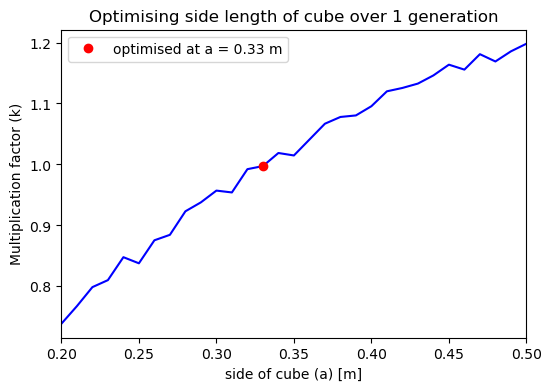

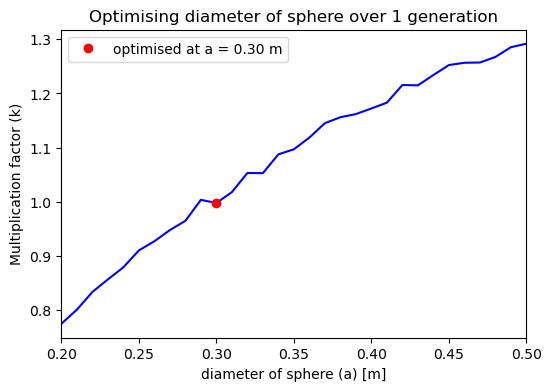

In [27]:
N = 250
mean_free_path = 0.15
trials = 250
shape = 'cube'                      # 'cube' or 'sphere'
gen = 50
# Probability range of reaction occuring in probability grid (different purity areas)
p_min = 0.5
p_max = 1

[k_ave_ls_cube, k_std_ls_cube, k_min_ls_cube, k_max_ls_cube, N_ave_ls_cube, N_std_ls_cube], a_cube = optimise_a(gen, N, mean_free_path, trials, shape, p_min, p_max)

shape = 'sphere'

[k_ave_ls_sphere, k_std_ls_sphere, k_min_ls_sphere, k_max_ls_sphere, N_ave_ls_sphere, N_std_ls_sphere], a_sphere = optimise_a(gen, N, mean_free_path, trials, shape, p_min, p_max)

**Note:** To improve readability, the histogram plots are attached as separate files in the submission.

### Graphs for Analysis

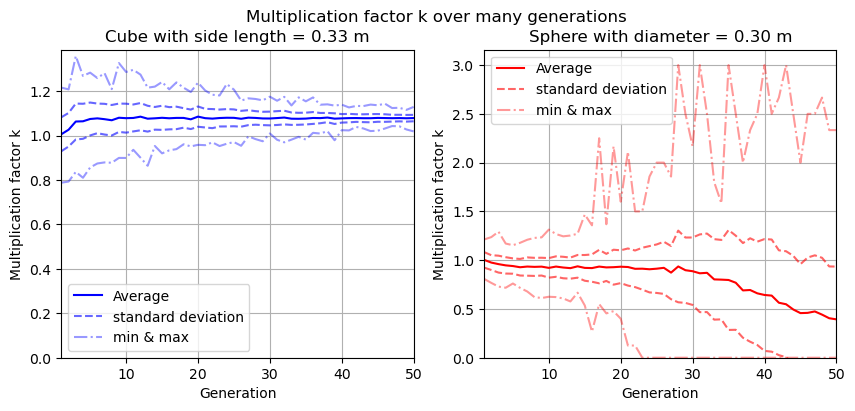

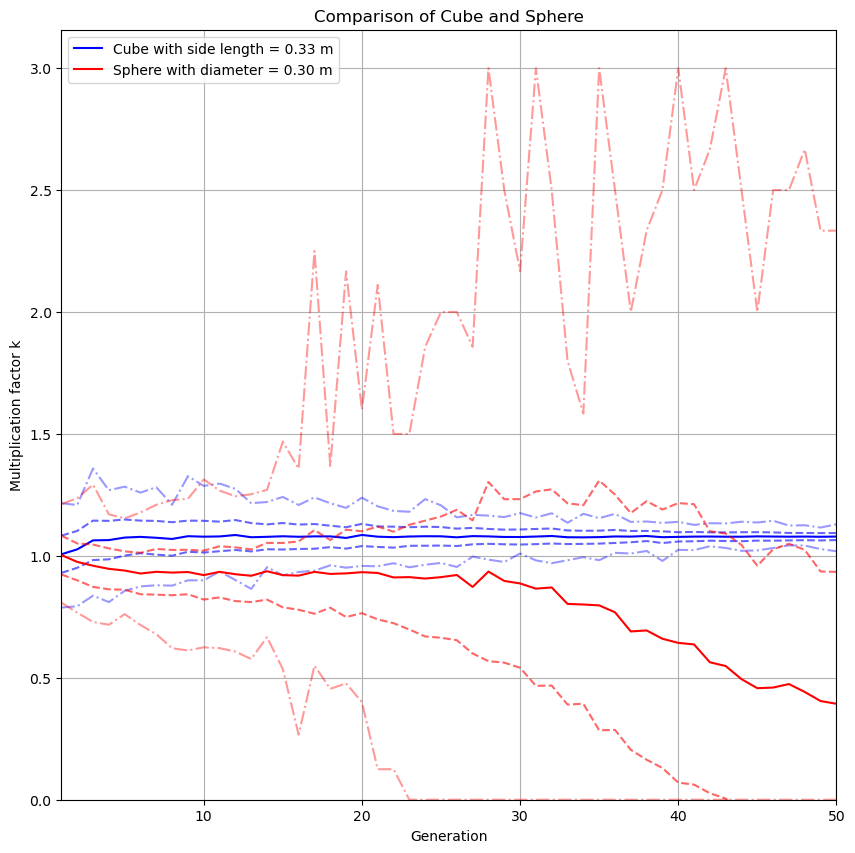

In [82]:
# to graph turn k lists into numpy arrays
k_cube = np.array(k_ave_ls_cube)
k_std_cube = np.array(k_std_ls_cube)
k_min_cube = np.array(k_min_ls_cube)
k_max_cube = np.array(k_max_ls_cube)
k_sphere = np.array(k_ave_ls_sphere)
k_std_sphere = np.array(k_std_ls_sphere)
k_min_sphere = np.array(k_min_ls_sphere)
k_max_sphere = np.array(k_max_ls_sphere)

gen_ls = np.arange(1,gen+1)



fig, axes = plt.subplots(1,2, figsize = (10,4))

axes[0].plot(gen_ls, k_cube, color = 'blue', label = 'Average')
axes[0].plot(gen_ls, k_cube + k_std_cube, linestyle = '--', color = 'blue', label = 'standard deviation', alpha=0.6)
axes[0].plot(gen_ls, k_cube - k_std_cube, linestyle = '--', color = 'blue', alpha=0.6)
axes[0].plot(gen_ls, k_min_cube, linestyle = '-.', color = 'blue', label = 'min & max', alpha=0.4)
axes[0].plot(gen_ls, k_max_cube, linestyle = '-.', color = 'blue', alpha=0.4)
axes[0].set_xlim(1,gen)
axes[0].set_ylim(0)
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("Multiplication factor k")
axes[0].set_title(f'Cube with side length = {a_cube:.2f} m')
axes[0].grid()
axes[0].legend()

axes[1].plot(gen_ls, k_sphere, color = 'red', label = 'Average')
axes[1].plot(gen_ls, k_sphere + k_std_sphere, linestyle = '--', color = 'red', label = 'standard deviation', alpha=0.6)
axes[1].plot(gen_ls, k_sphere - k_std_sphere, linestyle = '--', color = 'red', alpha=0.6)
axes[1].plot(gen_ls, k_min_sphere, linestyle = '-.', color = 'red', label = 'min & max', alpha=0.4)
axes[1].plot(gen_ls, k_max_sphere, linestyle = '-.', color = 'red', alpha=0.4)
axes[1].set_xlim(1,gen)
axes[1].set_ylim(0)
axes[1].set_xlabel("Generation")
axes[1].set_ylabel("Multiplication factor k")
axes[1].set_title(f'Sphere with diameter = {a_sphere:.2f} m')
axes[1].legend()
axes[1].grid()

fig.suptitle("Multiplication factor k over many generations")
plt.show()

fig, axes = plt.subplots(figsize=(10, 10))

axes.plot(gen_ls, k_cube, color = 'blue', label = f'Cube with side length = {a_cube:.2f} m')
axes.plot(gen_ls, k_cube + k_std_cube, linestyle = '--', color = 'blue', alpha=0.6)
axes.plot(gen_ls, k_cube - k_std_cube, linestyle = '--', color = 'blue', alpha=0.6)
axes.plot(gen_ls, k_min_cube, linestyle = '-.', color = 'blue', alpha=0.4)
axes.plot(gen_ls, k_max_cube, linestyle = '-.', color = 'blue', alpha=0.4)



axes.plot(gen_ls, k_sphere, color = 'red', label = f'Sphere with diameter = {a_sphere:.2f} m')
axes.plot(gen_ls, k_sphere + k_std_sphere, linestyle = '--', color = 'red', alpha=0.6)
axes.plot(gen_ls, k_sphere - k_std_sphere, linestyle = '--', color = 'red', alpha=0.6)
axes.plot(gen_ls, k_min_sphere, linestyle = '-.', color = 'red', alpha=0.4)
axes.plot(gen_ls, k_max_sphere, linestyle = '-.', color = 'red', alpha=0.4)
axes.set_xlim(1,gen)
axes.set_ylim(0)
axes.set_xlabel("Generation")
axes.set_ylabel("Multiplication factor k")
axes.set_title('Comparison of Cube and Sphere')
axes.legend()
axes.grid()
plt.show()

## Analysis

- For a cube $k_{0\rightarrow1}\approx 1$ when $a=0.33$ m. Over many generations the average value of the multiplication factor $k$ increases slightly before stabilising at around 1.08. Interestingly both the values within the standard deviation and the minimum and maximum $k$-values appear to converge to that value as well over the course of many generations.
- For a sphere $k_{0\rightarrow1}\approx1$ when $a=0.30$ m. Over several generations the average $k$-value initially decreases slightly and stabilises before starting to decline greatly. The graphs show however that the variability between different trials is substantial throughout all the calculated generations with the spread of $k$-values increasing to range from 0 – 3.

## Conclusion

- For a cube, the multiplication factor $k$ will stabilise to a value very close to 1 over 50 generations if the dimensions are adjusted (to a side length of 0.33 m with these parameters). This is further supported as the spread of $k$-values decreases over the course of the 50 generations. This means a cubic sample would work well for Fermi's experiments as the reaction remains critical for at least 50 generations.
- For a sphere on the other hand, the multiplication factor $k$ decreases on average over 50 generations (for initial diameter of 0.30 m which results in initial $k$-value of 1). Despite that the spread increases substantially in both directions. This means a spherical sample would not be good for Fermi's experiments as it would be impossible to guarantee a critical fission reaction over many generations and both subcritical and supercritical scenarios would be possible.

## References

[1] Encyclopaedia Britannica. (n.d.). Uranium-235. Encyclopaedia Britannica. Retrieved November 25, 2024, from https://www.britannica.com/science/uranium-235

[2] The Matplotlib Development Team. (n.d.). 3D plotting — Matplotlib 3.7.1 documentation. Matplotlib. Retrieved November 25, 2024, from https://matplotlib.org/stable/gallery/mplot3d/index.html

[3] The NumPy Community. (n.d.). NumPy. NumPy. Retrieved November 25, 2024, from https://numpy.org/